<table style="float: left; width: 50%;">
    <thead>
        <tr>
            <th style="background-color: #ADD8E6; color: black; text-align: left; padding: 8px;">NIM</th>
            <th style="background-color: #ADD8E6; color: black; text-align: left; padding: 8px;">Nama</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align: left; padding: 8px;">12S19036</td>
            <td style="text-align: left; padding: 8px;">Lucas Hutabarat</td>
        </tr>
        <tr>
            <td style="text-align: left; padding: 8px;">12S21004</td>
            <td style="text-align: left; padding: 8px;">Estomihi Pangaribuan</td>
        </tr>
        <tr>
            <td style="text-align: left; padding: 8px;">12S21014</td>
            <td style="text-align: left; padding: 8px;">Fritz Kevin Manurung</td>
        </tr>
    </tbody>
</table>

### Import Library

In [1]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import GridSearchCV
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

warnings.filterwarnings("ignore")

In [2]:

# ------------------------------------------
# 1. Data Preprocessing
# ------------------------------------------

# Load dataset
data = pd.read_csv("data/Tempat-Wisata-Toba-Preprocessing.csv")
data = data.drop(columns=["Unnamed: 0", "Unnamed: 0.1", "address"])

# Check missing values
print("Persentase Missing Value Rating: ", data["Rating"].isnull().sum()/len(data)*100)
print("Persentase Missing Value Reviews: ", data["Reviews"].isnull().sum()/len(data)*100)

# Fill missing values
data["Rating"] = data["Rating"].fillna(data["Rating"].mean())
data["Reviews"] = data["Reviews"].fillna("")

# Normalisasi Rating 1-5 menjadi 0-1
scaler = MinMaxScaler()
data["Rating"] = scaler.fit_transform(data[["Rating"]])

# Split data: train-validation-test (70:15:15)
train, test = train_test_split(data, test_size=0.3, random_state=42)
validation, test = train_test_split(test, test_size=0.5, random_state=42)

# Pivot tabel untuk user-item matrix
user_item_matrix = train.pivot_table(index='ReviewerId', columns='PlaceID', values='Rating', fill_value=0)

Persentase Missing Value Rating:  0.0023134224772127887
Persentase Missing Value Reviews:  48.72067737010133


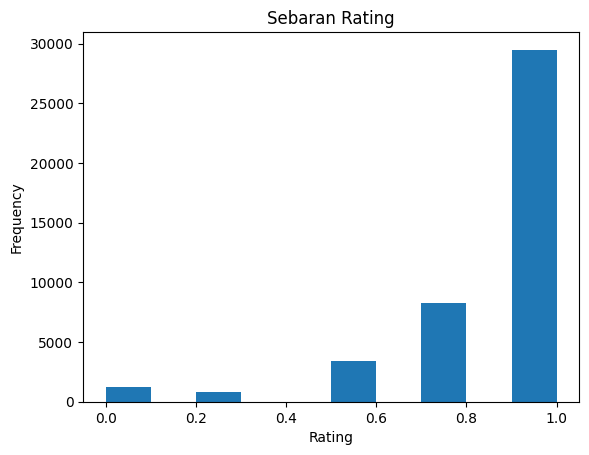

In [3]:
plt.hist(data["Rating"])
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Sebaran Rating")
plt.show()

Text(0, 0.5, 'Frequency')

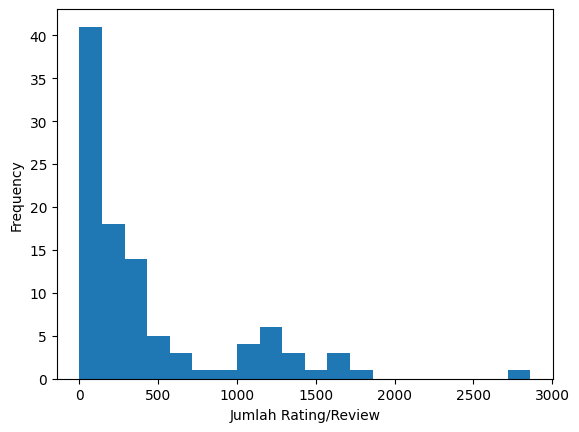

In [4]:
# cek seberapa sering suatu temmap wisata di rating maupun di review, lihat perbandingannya
plt.hist(data["PlaceID"].value_counts(), bins=20)
plt.xlabel("Jumlah Rating/Review")
plt.ylabel("Frequency")



In [5]:
# ------------------------------------------
# 2. Collaborative Filtering with SVD
# ------------------------------------------

# Load data ke dalam Dataset Surprise
reader = Reader(rating_scale=(0, 1))
data_surprise = Dataset.load_from_df(train[['ReviewerId', 'PlaceID', 'Rating']], reader)
data_surprise_test = Dataset.load_from_df(test[['ReviewerId', 'PlaceID', 'Rating']], reader)


# Hyperparameter tuning menggunakan GridSearchCV
param_grid = {'n_factors': [50, 100], 'lr_all': [0.002, 0.005], 'reg_all': [0.02, 0.1]}
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
grid_search.fit(data_surprise)

# Ambil hasil dari GridSearchCV
best_rmse = grid_search.best_score['rmse']
best_params = grid_search.best_params['rmse']

# Tampilkan parameter terbaik dan RMSE terbaik
print(f"Best RMSE: {best_rmse}")
print(f"Best parameters from GridSearchCV: {best_params}")



Best RMSE: 0.22877221923657462
Best parameters from GridSearchCV: {'n_factors': 50, 'lr_all': 0.005, 'reg_all': 0.1}


In [6]:
# ------------------------------------------
# 3. Train the model with best parameters
# ------------------------------------------

# Dapatkan parameter terbaik
model = SVD(n_factors=best_params['n_factors'], lr_all=best_params['lr_all'], reg_all=best_params['reg_all'])
model.fit(data_surprise.build_full_trainset())

In [7]:
# ------------------------------------------
# 4. Content-Based Filtering
# ------------------------------------------

# Menggabungkan Reviews berdasarkan PlaceID
place_reviews = train.groupby(['PlaceID', 'Nama_tempat_wisata'])['Reviews'].apply(lambda x: ' '.join(x)).reset_index()

# TF-IDF dan cosine similarity
stopwords = StopWordRemoverFactory().get_stop_words()
tfidf = TfidfVectorizer(stop_words=stopwords)
tfidf_matrix = tfidf.fit_transform(place_reviews['Reviews'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Mapping PlaceID ke index
place_indices = pd.Series(place_reviews.index, index=place_reviews['PlaceID'])

# Content-based recommendation function
def content_based_recommend(place_id, top_n=5):
    if place_id not in place_indices:
        print("PlaceID tidak ditemukan!")
        return
    idx = place_indices[place_id]
    sim_scores = sorted(list(enumerate(cosine_sim[idx])), key=lambda x: x[1], reverse=True)[1:top_n+1]
    place_indices_sim = [i[0] for i in sim_scores]
    return place_reviews.iloc[place_indices_sim][['PlaceID', 'Nama_tempat_wisata']].set_index('PlaceID')

In [8]:
def hybrid_recommend(user_id, top_n=5, weight_svd=0.5, weight_cb=0.5):
    place_ids = train['PlaceID'].unique()
    hybrid_scores = []

    for place_id in place_ids:
        # Prediksi dari SVD
        pred_svd = model.predict(user_id, place_id).est
        
        # Skor kesamaan dari CBF
        idx = place_indices.get(place_id, None)
        if idx is not None:
            sim_scores = cosine_sim[idx].mean()
            hybrid_score = weight_svd * pred_svd + weight_cb * sim_scores
            hybrid_scores.append((place_id, hybrid_score))
    
    # Mengurutkan berdasarkan hybrid_score dan mengembalikan top_n
    top_places = sorted(hybrid_scores, key=lambda x: x[1], reverse=True)[:top_n]
    return pd.DataFrame(top_places, columns=['PlaceID', 'Hybrid_Score']).set_index('PlaceID')

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# ------------------------------------------
# 6. Hybrid Evaluation Metrics (RMSE & MAE)
# ------------------------------------------

def evaluate_hybrid_model(testset, model, place_indices, cosine_sim, weight_svd=0.5, weight_cb=0.5):
    true_ratings = []  # Daftar untuk menyimpan nilai asli (true ratings)
    predicted_ratings = []  # Daftar untuk menyimpan nilai prediksi dari model hybrid

    # Prediksi dari Hybrid Recommender
    for uid, iid, true_r in testset:
        # Dapatkan rekomendasi hybrid untuk user tertentu
        hybrid_pred = hybrid_recommend(uid, top_n=10, weight_svd=weight_svd, weight_cb=weight_cb)

        # Periksa apakah iid ada dalam rekomendasi hybrid
        if iid in hybrid_pred.index:
            # Ambil prediksi rating berdasarkan Hybrid_Score
            predicted_rating = hybrid_pred.loc[iid, 'Hybrid_Score']
        else:
            predicted_rating = model.predict(uid, iid).est
        
        # Simpan nilai asli dan prediksi untuk evaluasi
        true_ratings.append(true_r)
        predicted_ratings.append(predicted_rating)
        
    # Menghitung RMSE dan MAE
    rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
    mae = mean_absolute_error(true_ratings, predicted_ratings)
    
    return rmse, mae

# ------------------------------------------
# 7. Run Hybrid Evaluations
# ------------------------------------------

# Ambil testset dari data surprise
testset = data_surprise_test.build_full_trainset().build_testset()

# Evaluasi Hybrid Model
hybrid_rmse, hybrid_mae = evaluate_hybrid_model(testset, model, place_indices, cosine_sim, weight_svd=0.5, weight_cb=0.5)

# Print hasil evaluasi Hybrid Model
print(f"Hybrid Model RMSE: {hybrid_rmse:.4f}")
print(f"Hybrid Model MAE: {hybrid_mae:.4f}")


Hybrid Model RMSE: 0.2678
Hybrid Model MAE: 0.2149


In [10]:
# ------------------------------------------
# 6. Evaluasi Hybrid Model - Precision@K, Recall@K, MAP@K
# ------------------------------------------

def precision_recall_at_k_hybrid(predictions, k=5, weight_svd=0.5, weight_cb=0.5):
    user_est_true = defaultdict(list)
    
    # Organisasi prediksi berdasarkan user untuk Hybrid Model
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((iid, true_r, est))

    precisions, recalls = [], []
    for uid, user_ratings in user_est_true.items():
        # Urutkan berdasarkan skor prediksi hybrid (descending order)
        user_ratings.sort(key=lambda x: x[2], reverse=True)
        top_k = user_ratings[:k]

        # Menghitung Precision dan Recall
        n_rel = sum((true_r >= 0.5) for (_, true_r, _) in user_ratings)  # Jumlah relevansi
        n_rec_k = sum((true_r >= 0.5) for (_, true_r, _) in top_k)  # Jumlah relevansi di top-K
        precision = n_rec_k / k
        recall = n_rec_k / n_rel if n_rel else 0

        precisions.append(precision)
        recalls.append(recall)

    # Mengembalikan rata-rata Precision@K dan Recall@K
    return np.mean(precisions), np.mean(recalls)

def average_precision_at_k_hybrid(predictions, k=5, weight_svd=0.5, weight_cb=0.5):
    user_est_true = defaultdict(list)

    # Organisasi prediksi berdasarkan user untuk Hybrid Model
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((iid, true_r, est))

    average_precisions = []

    for uid, user_ratings in user_est_true.items():
        # Urutkan berdasarkan skor prediksi hybrid (descending order)
        user_ratings.sort(key=lambda x: x[2], reverse=True)
        top_k = user_ratings[:k]

        # Menghitung Average Precision
        n_rel = sum((true_r >= 0.5) for (_, true_r, _) in user_ratings)
        n_rec_k = sum((true_r >= 0.5) for (_, true_r, _) in top_k)

        ap = 0.0
        relevant_items = 0
        for i, (_, true_r, _) in enumerate(top_k, start=1):
            if true_r >= 0.5:  # Jika item relevan
                relevant_items += 1
                ap += relevant_items / i
        
        if relevant_items > 0:
            ap /= relevant_items
        average_precisions.append(ap)

    # MAP@K
    mean_ap = np.mean(average_precisions) if average_precisions else 0
    return mean_ap

# ------------------------------------------
# 7. Evaluasi untuk Hybrid Model
# ------------------------------------------

# Test predictions dari model hybrid
testset = data_surprise_test.build_full_trainset().build_testset()
predictions_hybrid = []
for uid, iid, true_r in testset:

    hybrid_pred = hybrid_recommend(uid, top_n=10, weight_svd=0.5, weight_cb=0.5)
    if iid in hybrid_pred.index:
        predicted_rating = hybrid_pred.loc[iid, 'Hybrid_Score']
    else:
        predicted_rating = model.predict(uid, iid).est
    predictions_hybrid.append((uid, iid, true_r, predicted_rating, ''))

# Evaluasi model hybrid
precision_5, recall_5 = precision_recall_at_k_hybrid(predictions_hybrid, k=5, weight_svd=0.5, weight_cb=0.5)
map_5 = average_precision_at_k_hybrid(predictions_hybrid, k=5, weight_svd=0.5, weight_cb=0.5)

precision_10, recall_10 = precision_recall_at_k_hybrid(predictions_hybrid, k=10, weight_svd=0.5, weight_cb=0.5)
map_10 = average_precision_at_k_hybrid(predictions_hybrid, k=10, weight_svd=0.5, weight_cb=0.5)



In [11]:
# Print evaluation results
print(f"Precision@5: {precision_5:.4f}")
print(f"Recall@5: {recall_5:.4f}")
print(f"MAP@5: {map_5:.4f}")

print(f"Precision@10: {precision_10:.4f}")
print(f"Recall@10: {recall_10:.4f}")
print(f"MAP@10: {map_10:.4f}")

Precision@5: 0.2408
Recall@5: 0.9596
MAP@5: 0.9556
Precision@10: 0.1205
Recall@10: 0.9598
MAP@10: 0.9556


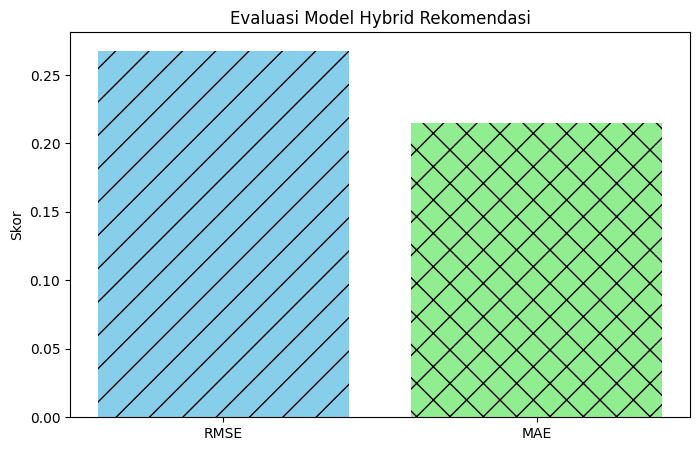

In [12]:
# Data evaluasi untuk Hybrid
hybrid_metrics = ['RMSE', 'MAE']
hybrid_values = [hybrid_rmse, hybrid_mae]

# Visualisasi dengan pola
plt.figure(figsize=(8, 5))
plt.bar(hybrid_metrics, hybrid_values, color=['skyblue', 'lightgreen'], hatch=['/', 'x'])
plt.title('Evaluasi Model Hybrid Rekomendasi')
plt.ylabel('Skor')
plt.show()

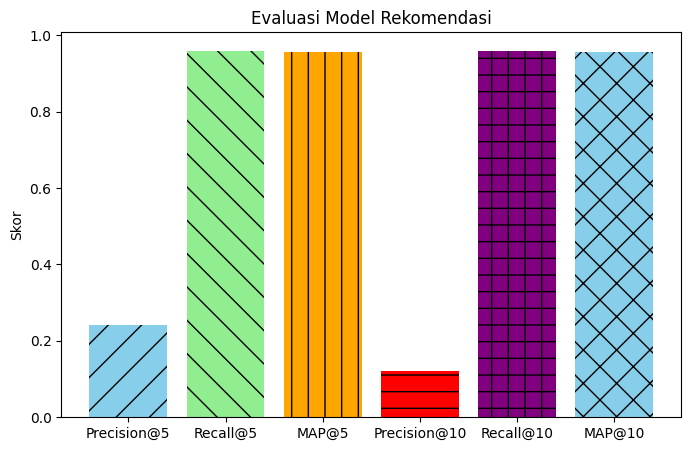

In [13]:
# Tampilkan chart precision@5, recall@5, map@5
metrics = ['Precision@5', 'Recall@5', 'MAP@5', 'Precision@10', 'Recall@10', 'MAP@10']
values = [precision_5, recall_5, map_5, precision_10, recall_10, map_10]

# Visualisasi dengan pola
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'orange', 'red', 'purple'], hatch=['/', '\\', '|', '-', '+', 'x'])
plt.title('Evaluasi Model Rekomendasi')
plt.ylabel('Skor')
plt.show()

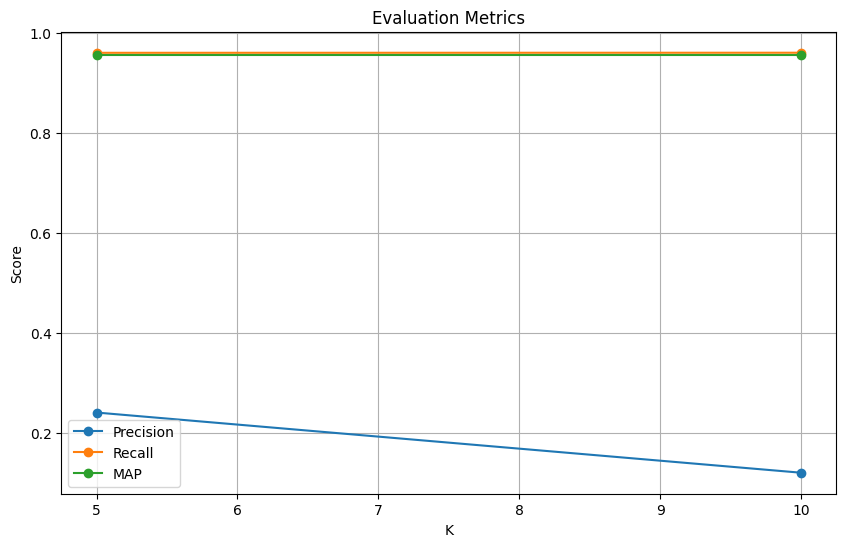

In [14]:
# grafik evaluasi
plt.figure(figsize=(10, 6))
plt.plot([5, 10], [precision_5, precision_10], marker='o', label='Precision')
plt.plot([5, 10], [recall_5, recall_10], marker='o', label='Recall')
plt.plot([5, 10], [map_5, map_10], marker='o', label='MAP')
plt.xlabel('K')
plt.ylabel('Score')
plt.title('Evaluation Metrics')
plt.legend()
plt.grid()
plt.show()

In [15]:
#rekomenadasi pariwisata untuk user id 1.04743e+20 dengan metode hybrid
print("Top 5 Rekomendasi Tempat Wisata untuk User ID 1.04743e+20:")
print(hybrid_recommend(1.04743e+20, top_n=5))


Top 5 Rekomendasi Tempat Wisata untuk User ID 1.04743e+20:
         Hybrid_Score
PlaceID              
101          0.647448
52           0.634954
92           0.629677
100          0.628921
91           0.624909


In [16]:
#rekomenadasi pariwisata untuk user id 1.04743e+20 dengan metode hybrid
print("Top 10 Rekomendasi Tempat Wisata untuk User ID 1.04743e+20:")
print(hybrid_recommend(1.04743e+20, top_n=10))

Top 10 Rekomendasi Tempat Wisata untuk User ID 1.04743e+20:
         Hybrid_Score
PlaceID              
101          0.647448
52           0.634954
92           0.629677
100          0.628921
91           0.624909
66           0.619780
60           0.611903
97           0.608349
88           0.606966
69           0.605716


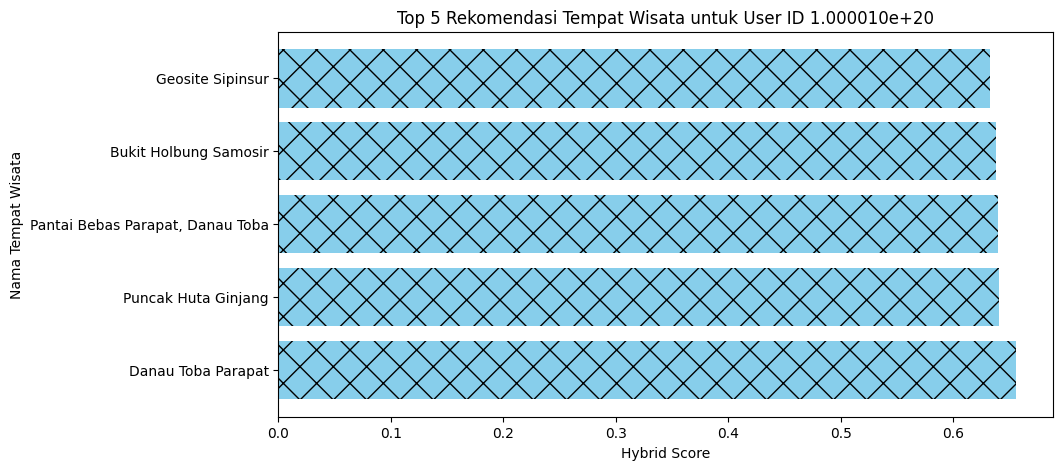

In [17]:
# Top 5 rekomendasi tempat wisata untuk user id 1.000010e+20 dengan pola
top_5 = hybrid_recommend(1.000010e+20, top_n=5).reset_index()
top_5 = top_5.merge(place_reviews[['PlaceID', 'Nama_tempat_wisata']], on='PlaceID')
plt.figure(figsize=(10, 5))
plt.barh(top_5['Nama_tempat_wisata'], top_5['Hybrid_Score'], color='skyblue', hatch='x')
plt.xlabel('Hybrid Score')
plt.ylabel('Nama Tempat Wisata')
plt.title('Top 5 Rekomendasi Tempat Wisata untuk User ID 1.000010e+20')
plt.show()

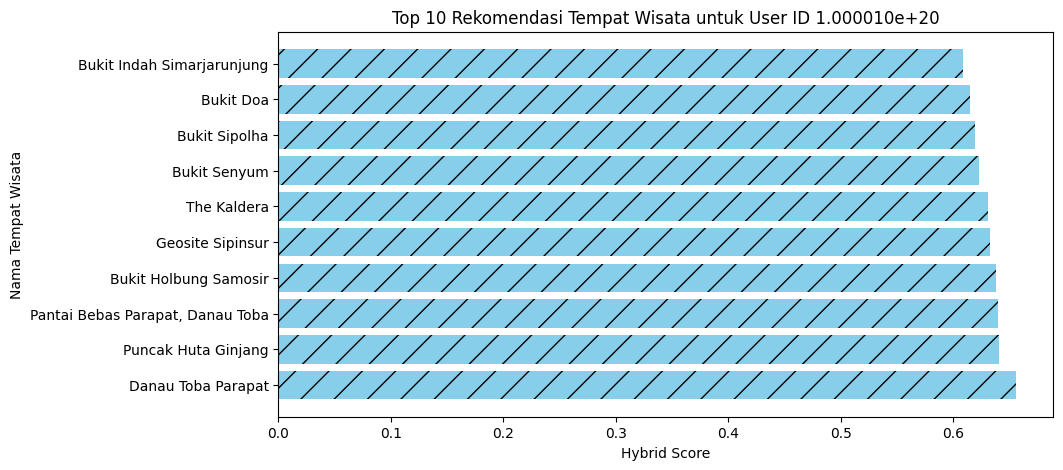

In [18]:
# Top 10 rekomendasi tempat wisata untuk user id 1.000010e+20 dengan pola
top_10 = hybrid_recommend(1.000010e+20, top_n=10).reset_index()
top_10 = top_10.merge(place_reviews[['PlaceID', 'Nama_tempat_wisata']], on='PlaceID')
plt.figure(figsize=(10, 5))
plt.barh(top_10['Nama_tempat_wisata'], top_10['Hybrid_Score'], color='skyblue', hatch='/')
plt.xlabel('Hybrid Score')
plt.ylabel('Nama Tempat Wisata')
plt.title('Top 10 Rekomendasi Tempat Wisata untuk User ID 1.000010e+20')
plt.show()